In [42]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [19]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode='categorical',
                                                                    batch_size=BATCH_SIZE, image_size=IMG_SIZE)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode='categorical',
                                                                   batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [4]:
data_augmentation = Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip('horizontal')
], name='data_augmentation')

In [5]:
checkpoint_path = 'model_checkpoints/min_val_loss'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                               save_best_only=True,
                                                               save_weights_only=True,
                                                               monitor='val_loss', mode='min')

In [6]:
import time
logdir = 'transfer_learning/{}'.format(time.time())
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [7]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalMaxPooling2D(name='global_average_pooling_layer')(x)
outputs = Dense(10, activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, validation_steps=int(0.25*len(test_dataset)),
                    callbacks=[tensorboard_callback, model_checkpoint_callback])

16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/10
24/24 [==============================] - 45s 2s/step - loss: 3.6531 - accuracy: 0.2200 - val_loss: 2.1025 - val_accuracy: 0.4227
Epoch 2/10
24/24 [==============================] - 36s 2s/step - loss: 1.8284 - accuracy: 0.4760 - val_loss: 1.4683 - val_accuracy: 0.6135
Epoch 3/10
24/24 [==============================] - 36s 2s/step - loss: 1.4709 - accuracy: 0.5693 - val_loss: 1.0486 - val_accuracy: 0.6908
Epoch 4/10
24/24 [==============================] - 36s 2s/step - loss: 1.1878 - accuracy: 0.6560 - val_loss: 0.9821 - val_accuracy: 0.7204
Epoch 5/10
24/24 [==============================] - 36s 2s/step - loss: 1.0205 - accuracy: 0.6827 - val_loss: 0.8714 - val_accuracy: 0.7500
Epoch 6/10
24/24 [==============================] - 38s 2s/step - loss: 0.8860 - accuracy: 0.7400 - val_loss: 0.8230 - val_accuracy: 0.7648
Epoch 7/10
24/24 [==============================] - 36s 2s/step - loss: 0.7925 - accuracy: 0.76

In [8]:
model.evaluate(test_dataset)

79/79 [==============================] - 65s 823ms/step - loss: 0.7986 - accuracy: 0.7744


[0.7986395955085754, 0.774399995803833]

In [9]:
for idx, layer in enumerate(model.layers):
    print(idx, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7f9d657858b0> True
1 <keras.engine.sequential.Sequential object at 0x7f9d6478b5e0> True
2 <keras.engine.functional.Functional object at 0x7f9d46a73a90> False
3 <keras.layers.pooling.global_max_pooling2d.GlobalMaxPooling2D object at 0x7f9d647b7a00> True
4 <keras.layers.core.dense.Dense object at 0x7f9d46e2a580> True


### Finetune 30 last layer of EfficientNetB0

In [10]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False
    
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(0.0001), metrics=['accuracy'])
finetune_epochs = 10 + 10
finetune_history = model.fit(train_dataset, epochs=finetune_epochs, initial_epoch=history.epoch[-1],
                             validation_data=test_dataset, validation_steps=int(0.25*len(test_dataset)),
                             callbacks=[tensorboard_callback, model_checkpoint_callback])

Epoch 10/20
24/24 [==============================] - 51s 2s/step - loss: 0.5204 - accuracy: 0.8293 - val_loss: 0.7077 - val_accuracy: 0.7961
Epoch 11/20
24/24 [==============================] - 39s 2s/step - loss: 0.4131 - accuracy: 0.8773 - val_loss: 0.6540 - val_accuracy: 0.8043
Epoch 12/20
24/24 [==============================] - 37s 2s/step - loss: 0.3143 - accuracy: 0.8880 - val_loss: 0.6727 - val_accuracy: 0.8043
Epoch 13/20
24/24 [==============================] - 38s 2s/step - loss: 0.2688 - accuracy: 0.9133 - val_loss: 0.6187 - val_accuracy: 0.8158
Epoch 14/20
24/24 [==============================] - 38s 2s/step - loss: 0.1857 - accuracy: 0.9413 - val_loss: 0.5682 - val_accuracy: 0.8306
Epoch 15/20
24/24 [==============================] - 37s 2s/step - loss: 0.2050 - accuracy: 0.9320 - val_loss: 0.6417 - val_accuracy: 0.8240
Epoch 16/20
24/24 [==============================] - 39s 2s/step - loss: 0.1458 - accuracy: 0.9573 - val_loss: 0.6157 - val_accuracy: 0.8306
Epoch 17/20
2

In [11]:
model.evaluate(test_dataset)

79/79 [==============================] - 62s 778ms/step - loss: 0.6263 - accuracy: 0.8324


[0.6262834668159485, 0.8324000239372253]

In [12]:
for idx, layer in enumerate(model.layers):
    print(idx, layer, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7f9d657858b0> True
1 <keras.engine.sequential.Sequential object at 0x7f9d6478b5e0> True
2 <keras.engine.functional.Functional object at 0x7f9d46a73a90> True
3 <keras.layers.pooling.global_max_pooling2d.GlobalMaxPooling2D object at 0x7f9d647b7a00> True
4 <keras.layers.core.dense.Dense object at 0x7f9d46e2a580> True


### Plot sample predictions

In [38]:
class_names = test_dataset.class_names

In [57]:
def plot_sample_pred(dataset, cls_model, cls_names):
    test_sample_batch = iter(dataset.take(1)).next()
    sample_idx = np.random.choice(range(BATCH_SIZE))
    sample_img, sample_label = test_sample_batch[0][sample_idx], test_sample_batch[1][sample_idx]
    
    pred_probs = cls_model.predict(tf.expand_dims(sample_img, axis=0))
    pred_class = cls_names[tf.argmax(pred_probs[0]).numpy()]
    label = cls_names[tf.argmax(sample_label).numpy()]
    
    plt.figure(figsize=(8, 8))
    plt.imshow(sample_img.numpy().astype(int))
    title = 'Groundtruth: {}\nPrediction: {}\nProbability: {:.2f}'.format(label, pred_class, tf.reduce_max(pred_probs[0]))
    color = 'green' if label == pred_class else 'red'
    plt.title(title, color=color)

1/1 [==============================] - 0s 47ms/step


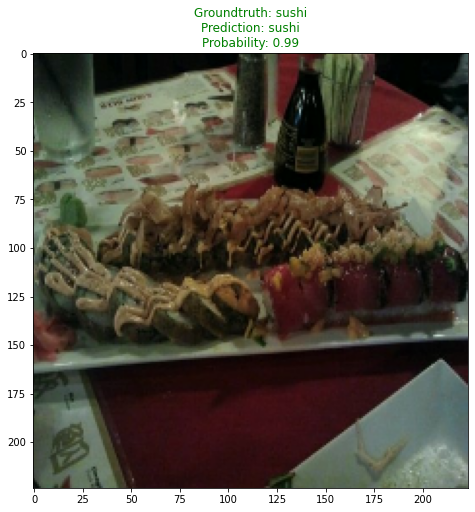

In [73]:
plot_sample_pred(test_dataset, model, class_names)